In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from operator import itemgetter

In [6]:
class Get_Chars:
    def __init__(self,image):
        self.image=image

    def non_max_suppression_fast(self,boxes, overlapThresh):
    # if there are no boxes, return an empty list
        if len(boxes) == 0:
            return []
        
        # if the bounding boxes integers, convert them to floats --
        # this is important since we'll be doing a bunch of divisions
        if boxes.dtype.kind == "i":
            boxes = boxes.astype("float")
        
        # initialize the list of picked indexes	
        pick = []
        
        # grab the coordinates of the bounding boxes
        x1 = boxes[:,0]
        y1 = boxes[:,1]
        x2 = boxes[:,2]
        y2 = boxes[:,3]
        
        # compute the area of the bounding boxes and sort the bounding
        # boxes by the bottom-right y-coordinate of the bounding box
        area = (x2 - x1 + 1) * (y2 - y1 + 1)
        idxs = np.argsort(y2)
        
        # keep looping while some indexes still remain in the indexes
        # list
        while len(idxs) > 0:
            # grab the last index in the indexes list and add the
            # index value to the list of picked indexes
            last = len(idxs) - 1
            i = idxs[last]
            pick.append(i)
        
            # find the largest (x, y) coordinates for the start of
            # the bounding box and the smallest (x, y) coordinates
            # for the end of the bounding box
            xx1 = np.maximum(x1[i], x1[idxs[:last]])
            yy1 = np.maximum(y1[i], y1[idxs[:last]])
            xx2 = np.minimum(x2[i], x2[idxs[:last]])
            yy2 = np.minimum(y2[i], y2[idxs[:last]])
        
            # compute the width and height of the bounding box
            w = np.maximum(0, xx2 - xx1 + 1)
            h = np.maximum(0, yy2 - yy1 + 1)
        
            # compute the ratio of overlap
            overlap = (w * h) / area[idxs[:last]]
        
            # delete all indexes from the index list that have
            idxs = np.delete(idxs, np.concatenate(([last],
                np.where(overlap > overlapThresh)[0])))
        
        # return only the bounding boxes that were picked using the
        # integer data type
        return boxes[pick].astype("int")
    def find_contours(self):
        imgray = cv2.cvtColor(self.image,cv2.COLOR_BGR2GRAY)
        blur = cv2.GaussianBlur(imgray,(3,3),1.03)
        thresh = cv2.adaptiveThreshold(blur,255,1,1,3,2)
        im2, contours, hierarchy = cv2.findContours(thresh,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
        boxes=[]
        for cnt in contours:
            x,y,w,h = cv2.boundingRect(cnt)
            if(w>100 or h<8):
                continue
            boxes.append([x,y,x+w,y+h])
        boxes=np.array(boxes)
        box=self.non_max_suppression_fast(boxes,0.2)#0.01
        return box
    #boxes_np=np.array(box)
    def top_affinity(self,boxes):
        y_top=set(boxes[:,1])
        affinity=[]
        for y in y_top:
            if(len(affinity)==0):
                affinity.append([y])
            else:
                nearest=0
                min_dist=1000000000
                for i in range(0,len(affinity)):
                    dist=abs(y-affinity[i][0])
                    if(dist<min_dist):
                        nearest=i
                        min_dist=dist
                if(min_dist<5):
                    if(y<affinity[nearest][0]):
                        affinity[nearest]=[y]+affinity[nearest]
                    else:
                        affinity[nearest].append(y)
                else:
                    affinity.append([y])
        return affinity
    def bottom_affinity(self,boxes):
        y_top=set(boxes[:,3])
        affinity=[]
        for y in y_top:
            if(len(affinity)==0):
                affinity.append([y])
            else:
                nearest=0
                min_dist=1000000000
                for i in range(0,len(affinity)):
                    dist=abs(y-affinity[i][0])
                    if(dist<min_dist):
                        nearest=i
                        min_dist=dist
                if(min_dist<5):
                    if(y>affinity[nearest][0]):
                        affinity[nearest]=[y]+affinity[nearest]
                    else:
                        affinity[nearest].append(y)
                else:
                    affinity.append([y])
        return affinity
    def get_boxes(self):
        box=self.find_contours()
        top_affinity_list=self.top_affinity(box)
        bottom_affinity_list=self.bottom_affinity(box)
        
        result_boxes=[]
        for i in range(len(box)):
            x1,y1,x2,y2=box[i]
            for i in range(len(top_affinity_list)):
                if(y1 in top_affinity_list[i]):
                    y1=top_affinity_list[i][0]
                    break
            for i in range(len(bottom_affinity_list)):
                if(y2 in bottom_affinity_list[i]):
                    y2=bottom_affinity_list[i][0]
                    break
            result_boxes.append([x1-1,y1-2,x2+1,y2+2])
        result_boxes=sorted(result_boxes,key=itemgetter(1,0))
        return result_boxes
    def pipeline(self):
        boxes=self.get_boxes()
        count=0
        for i in range(len(boxes)):
            x1,y1,x2,y2=boxes[i]
            cv2.imwrite('./chars/others/image'+str(count)+'.jpg',image[y1:y2,x1:x2])
            count+=1
            
        print('images generated',count)

In [7]:
image=cv2.imread('./data/image2.JPG')
print(image.shape)
obj=Get_Chars(image)
obj.pipeline()

(45, 226, 3)
images generated 7


In [16]:
image=cv2.imread('./data/untitled.png')
print(image.shape)

(25, 242, 3)


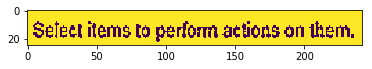

In [58]:
gray=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray,(3,3),0)
thresh = cv2.adaptiveThreshold(blur,10,1,0,3,1)
plt.imshow(thresh)


[  0   1   2   3   4  12  20  22  30  35  36  40  41  42  43  44  46  47
  50  57  60  61  64  65  68  74  75  76  77  78  82  89  90  91  92  93
  95 100 107 110 111 112 122 125 126 127 129 130 131 133 134 135 137 138
 139 140 141 148 154 155 158 161 168 169 171 172 173 175 176 182 183 184
 185 186 193 196 197 200 201 202 203 204 208 210 211 212 214 215 222 225
 226 229 230 232 233 234 235 236 237 238 239 240 241]


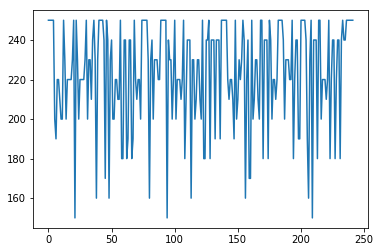

In [57]:
print(np.where(np.sum(thresh,axis=0)>230)[0])
plt.plot(np.sum(thresh,axis=0))